# **Final Project**

In [193]:
import os
import sys
import cv2
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import csv
import random

## 3. Dataset

Load Source Dataset (done locally)

In [194]:
path =os.path.join('.', 'QC')
np.set_printoptions(threshold=sys.maxsize)

In [195]:
rgb_dir = os.path.join(path, "rgb")
mask_dir = os.path.join(path, "mask")
csv_dir = os.path.join(path, "csv")
image_files = os.listdir(rgb_dir)
mask_files = os.listdir(mask_dir)
csv_files = os.listdir(csv_dir)
image_files.sort()
mask_files.sort()
csv_files.sort()

3.1 Plot Images for Sample Subject

In [196]:
def plot_sample_subject(image_path, mask_path):
    # Load the Image
    image = cv2.imread(image_path)
    # Load your mask image (assuming it's a binary image)
    mask_noChange = cv2.imread(mask_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    max = np.max(mask)
    
    #make overlay image
    overlayed = image.copy()

    for i in range(1, max):
        temp = np.where(mask == i, 1.0, 0.0).astype(np.uint8)
        contours, hierarchy = cv2.findContours(image=temp, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    
        cv2.drawContours(overlayed, contours=contours, contourIdx=-1, color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)

    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(cv2.cvtColor(mask_noChange, cv2.COLOR_BGR2RGB) )

    plt.subplot(1, 3, 3)
    plt.title("Mask Overlayed on Original Image")
    plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))

    plt.show()

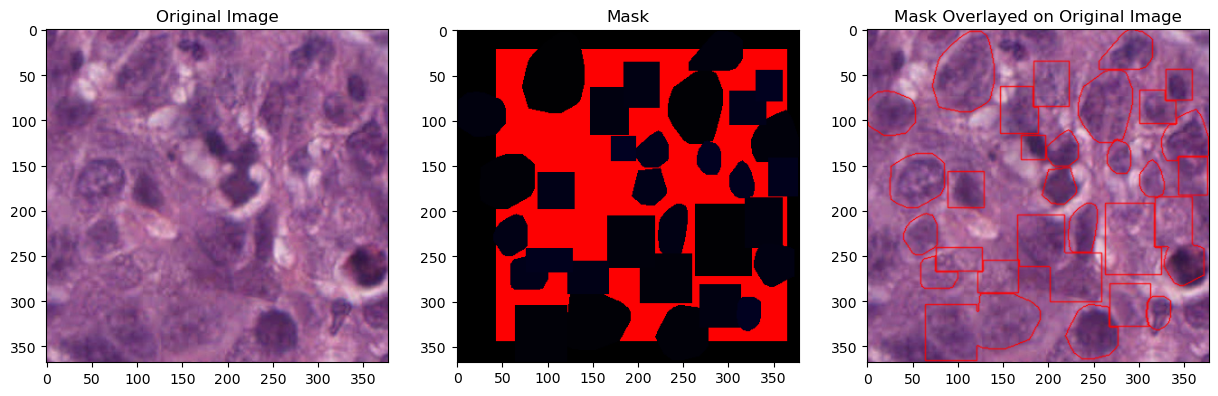

In [197]:
subject_id = "TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-11371_top-54469_bottom-54761_right-11671.png"

sample_image_path = os.path.join(rgb_dir, subject_id)
sample_mask_path = os.path.join(mask_dir, subject_id)

plot_sample_subject(sample_image_path,sample_mask_path )

In [198]:
def plot_sample(id, image_path, mask_path):
    # Load the Image
    image = cv2.imread(image_path + '.png')
    # Load your mask image (assuming it's a binary image)
    mask_noChange = cv2.imread(mask_path)
    mask = cv2.imread(mask_path + '.png', cv2.IMREAD_GRAYSCALE)
    max = np.max(mask)
    #make overlay image
    # overlayed = image.copy()

    df = pd.read_csv(os.path.join(csv_dir, id + '.csv')) # choose the first patient


    fontsize= 20
    plt.rcParams["figure.figsize"] = (20,6)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)

    plt.subplot(131)
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    plt.title('Original image',fontsize=fontsize)

    plt.subplot(132)
    ax2.imshow(mask)
    ax2.axis('off')
    plt.title('Mask',fontsize=fontsize)


    plt.subplot(133)
    ax3.imshow(image)
    ax3.axis('off')
    plt.title('Mask overlayed on Original Image', fontsize=fontsize)

    for i in range(df.shape[0]):

        if(df['type'][i]=='rectangle'):
            height = df['ymax'][i]-df['ymin'][i] 
            width = df['xmax'][i]-df['xmin'][i]
            patch = Rectangle((df['xmin'][i], df['ymin'][i]), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax3.add_patch(patch)

        elif(df['type'][i]=='polyline'):
            x = df['coords_x'][i].split(',')
            x = list(map(float, x))
            y = df['coords_y'][i].split(',')
            y = list(map(float, y))

        coords = []
        for i,elem in enumerate(x):
            xy = (elem,y[i])
            coords.append(xy)
            patch = Polygon(coords, linewidth=3, edgecolor='r', facecolor='none')
            ax3.add_patch(patch)

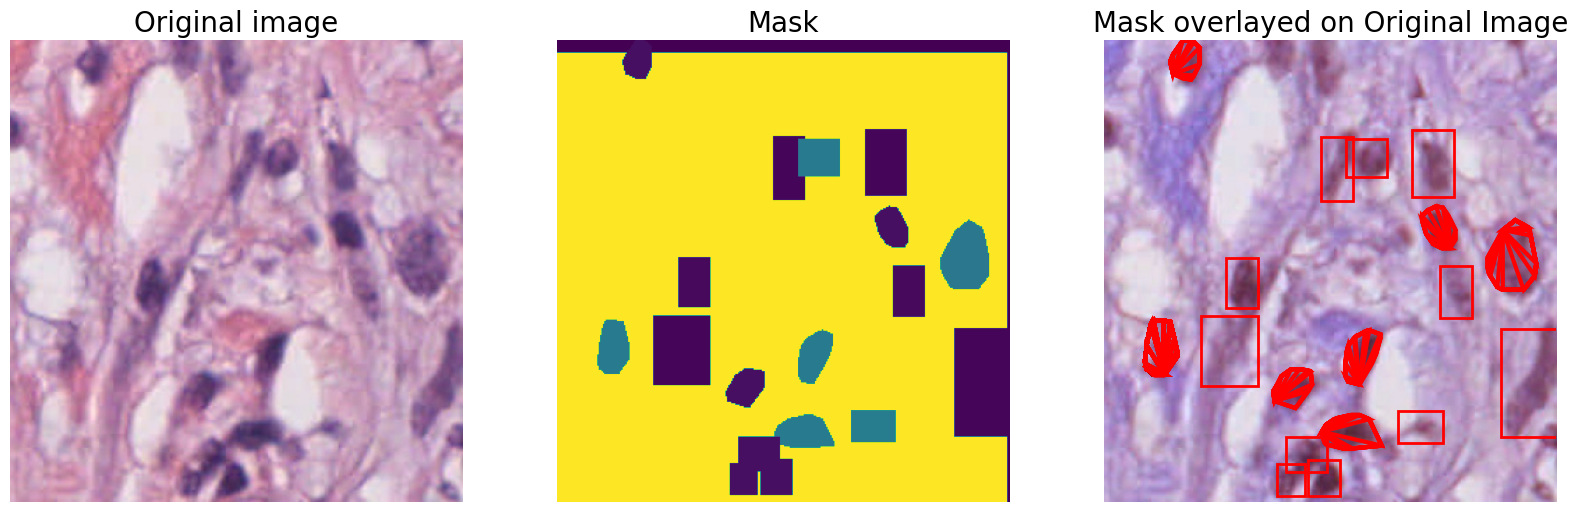

In [199]:
subject_id = "TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-7053_top-53967_bottom-54231_right-7311"

sample_image_path = os.path.join(rgb_dir, subject_id)
sample_mask_path = os.path.join(mask_dir, subject_id)

plot_sample(subject_id, sample_image_path, sample_mask_path)

3.2 Split Set: Training and Validation

In [200]:
# make folder for split
split_dir = os.path.join(path, "split")
os.makedirs(split_dir, exist_ok=True)

#all files names in RBG folder
filenames = os.listdir(rgb_dir)

#get all unique ids
unique_patient_ids = set()
for filename in filenames:
    # Extract the unique patient ID (first 4 parts of the filename)
    parts = filename.split("-")
    patient_id = "-".join(parts[:4])  # Combine first 4 parts
    patient_id = patient_id.split("_")[0]
    
    unique_patient_ids.add(patient_id)

unique_patient_ids = list(unique_patient_ids)
# Shuffle the list to ensure randomness
random.shuffle(unique_patient_ids)

In [201]:
#Split into training and validation sets (80% training, 20% validation)
split_index = int(0.8 * len(unique_patient_ids))
train_patient_ids = unique_patient_ids[:split_index]
validate_patient_ids = unique_patient_ids[split_index:]

In [202]:
# Save training patient IDs to trainsubjects.csv
with open(os.path.join(split_dir, "train_subjects.csv"), "w", newline="") as train_file:
    writer = csv.writer(train_file)
    writer.writerow(["PatientID"])  # Write header
    for patient_id in train_patient_ids:
        writer.writerow([patient_id])

# Save validation patient IDs to validatesubjects.csv
with open(os.path.join(split_dir, "validate_subjects.csv"), "w", newline="") as validate_file:
    writer = csv.writer(validate_file)
    writer.writerow(["PatientID"])  # Write header
    for patient_id in validate_patient_ids:
        writer.writerow([patient_id])